# Imports

In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import math 
import pylab 

from matplotlib.dates import DateFormatter
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
from glob import glob
from os import path
from collections import defaultdict
from virocon import (
    GlobalHierarchicalModel,
    ExponentiatedWeibullDistribution,
    WeibullDistribution,
    DependenceFunction,
    WidthOfIntervalSlicer,
    plot_marginal_quantiles,
    plot_dependence_functions,
    _fitting
)

from virocon._fitting import (
    fit_function,
    fit_constrained_function,
    convert_bounds_for_curve_fit,
)

import sys
sys.path.insert(0, path.abspath(path.join(path.curdir, '../src')))

%matplotlib notebook

# Data

In [2]:
# Read data

data = pd.read_csv('data_for_response_emulator.csv')
data= data.drop(columns=['Unnamed: 0'])
data= data.rename(columns={"peakDeflection": "peakDeflectionSBIT"})

<IPython.core.display.Javascript object>


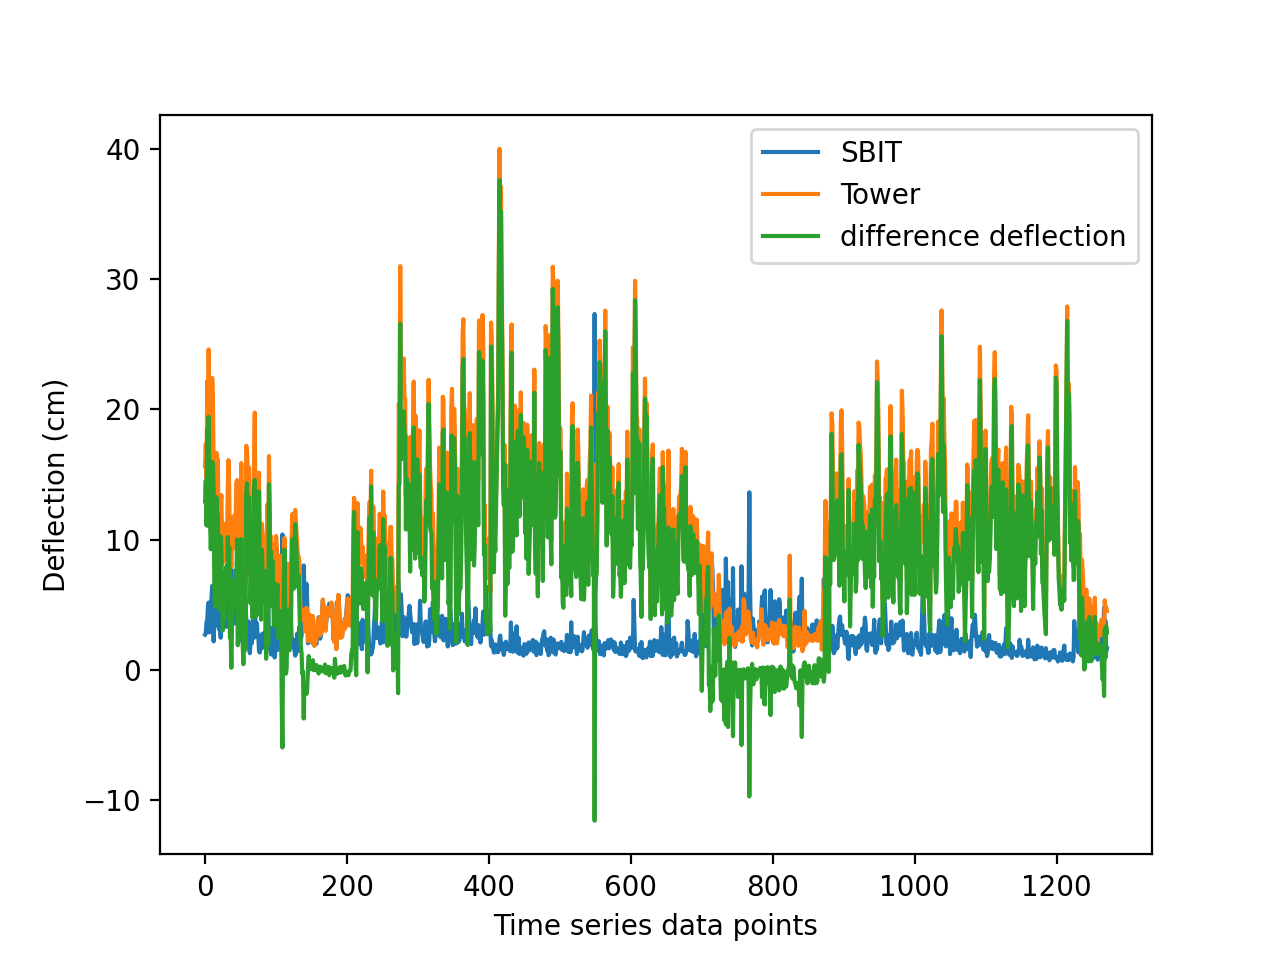

In [3]:
# Time series of deflection 

plt.figure()
plt.plot(data.peakDeflectionSBIT, label='SBIT')
plt.plot(data.peakDeflectionTower, label='Tower')
plt.plot(data.peakDeflectionTower- data.peakDeflectionSBIT, label='difference deflection')
plt.xlabel('Time series data points')
plt.ylabel('Deflection (cm)')
plt.legend()

In [4]:
# Drop datapoints where the difference between the towers deflection and the SBIT's deflection is less than 5cm
# Filter out points in time where SBIT and tower are connected

data = data.drop(data[(data.peakDeflectionTower- data.peakDeflectionSBIT) < 5].index)
data = data[data['windSpeed'].notna()]
data= data.reset_index(drop=True)

<IPython.core.display.Javascript object>


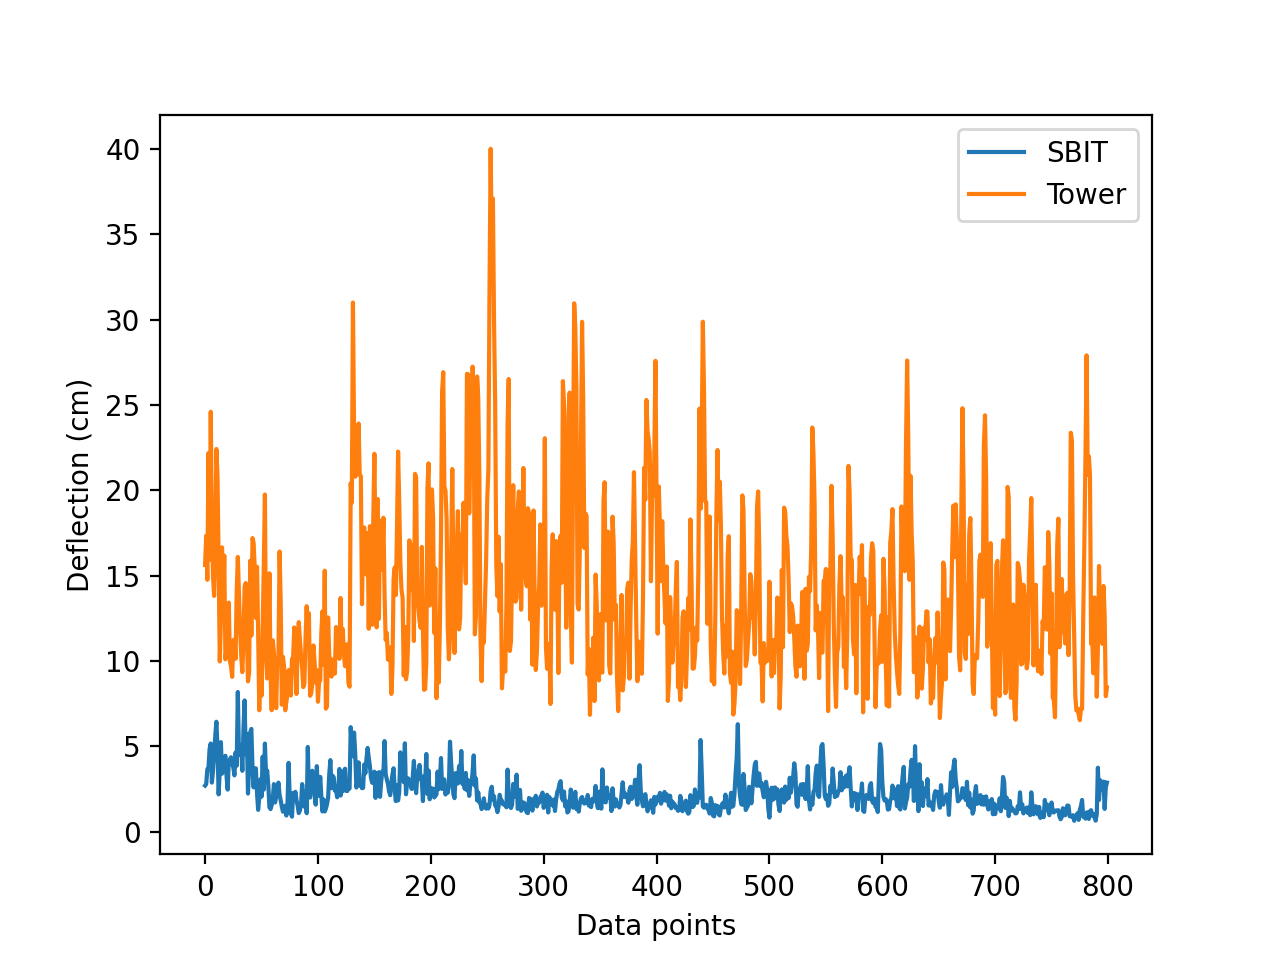

In [5]:
# filtered time series of SBIT and tower

plt.figure()
plt.plot(data.peakDeflectionSBIT, label='SBIT')
plt.plot(data.peakDeflectionTower, label='Tower')
plt.xlabel('Data points')
plt.ylabel('Deflection (cm)')
plt.legend()

<IPython.core.display.Javascript object>


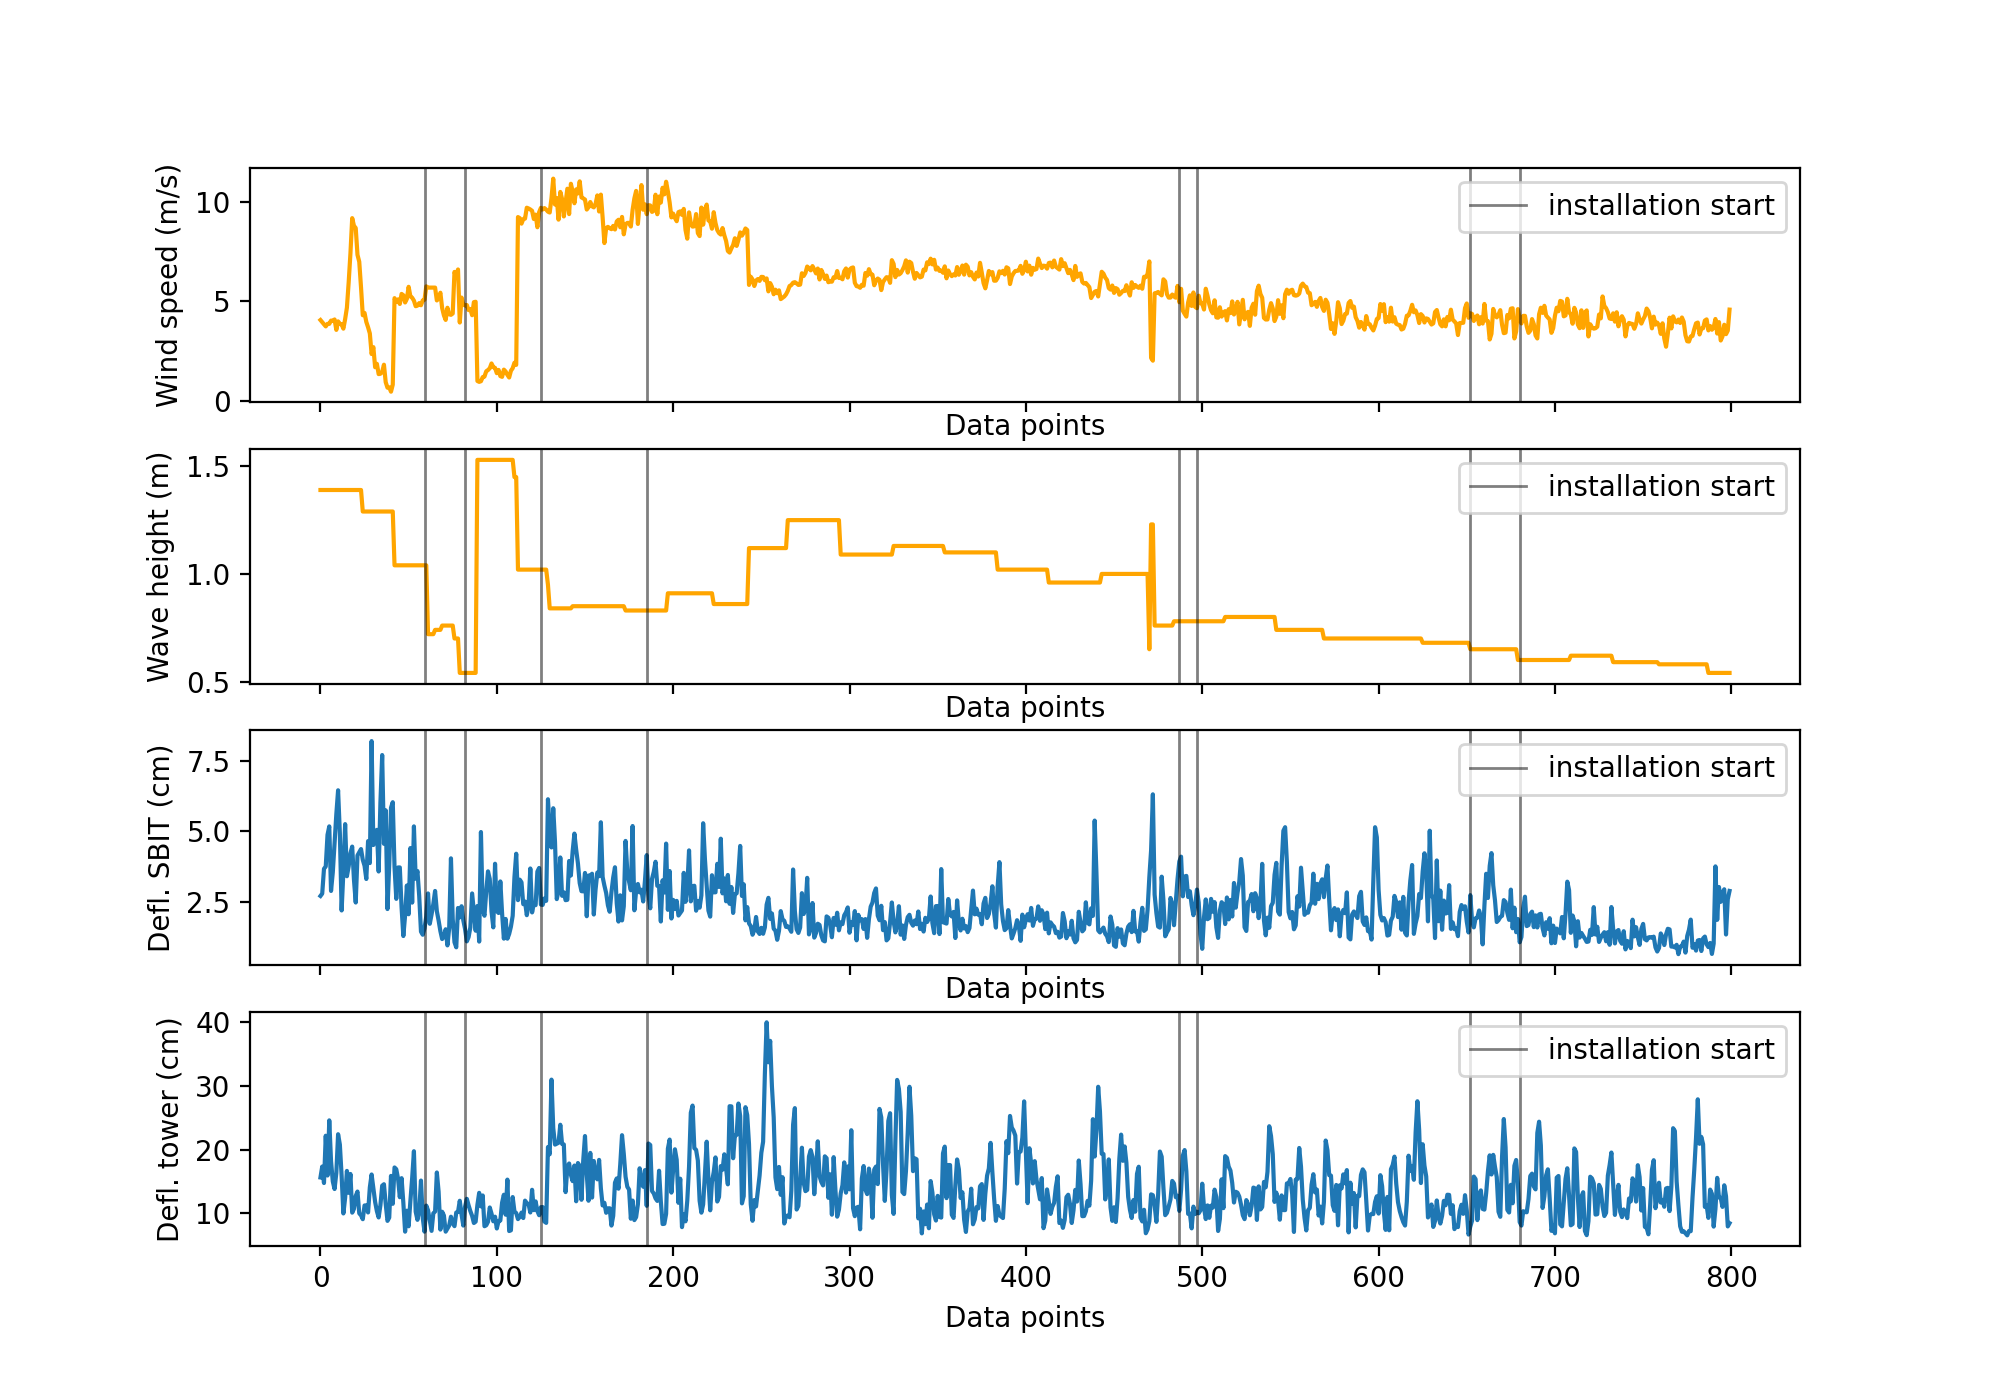

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex= True, figsize=(10,7))
ax1.plot(data.windSpeed, color= 'orange')
ax1.set_xlabel('Data points')
ax1.set_ylabel('Wind speed (m/s)')


ax1.axvline(x=59,alpha=0.5, color='k', linewidth=1, label='installation start')
ax1.axvline(x=82,alpha=0.5, color='k', linewidth=1)
ax1.axvline(x=125,alpha=0.5, color='k', linewidth=1)
ax1.axvline(x=185,alpha=0.5, color='k', linewidth=1)
ax1.axvline(x=487,alpha=0.5, color='k', linewidth=1)
ax1.axvline(x=497,alpha=0.5, color='k', linewidth=1)
ax1.axvline(x=652,alpha=0.5, color='k', linewidth=1)
ax1.axvline(x=680,alpha=0.5, color='k', linewidth=1)
ax1.legend(loc='upper right')

ax2.plot(data.waveHeight, color='orange')
ax2.set_xlabel('Data points')
ax2.set_ylabel('Wave height (m)')

ax2.axvline(x=59,alpha=0.5, color='k', linewidth=1, label='installation start')
ax2.axvline(x=82,alpha=0.5, color='k', linewidth=1)
ax2.axvline(x=125,alpha=0.5, color='k', linewidth=1)
ax2.axvline(x=185,alpha=0.5, color='k', linewidth=1)
ax2.axvline(x=487,alpha=0.5, color='k', linewidth=1)
ax2.axvline(x=497,alpha=0.5, color='k', linewidth=1)
ax2.axvline(x=652,alpha=0.5, color='k', linewidth=1)
ax2.axvline(x=680,alpha=0.5, color='k', linewidth=1)
ax2.legend(loc='upper right')

ax3.plot(data.peakDeflectionSBIT)
ax3.set_xlabel('Data points')
ax3.set_ylabel('Defl. SBIT (cm)')

ax3.axvline(x=59,alpha=0.5, color='k', linewidth=1, label='installation start')
ax3.axvline(x=82,alpha=0.5, color='k', linewidth=1)
ax3.axvline(x=125,alpha=0.5, color='k', linewidth=1)
ax3.axvline(x=185,alpha=0.5, color='k', linewidth=1)
ax3.axvline(x=487,alpha=0.5, color='k', linewidth=1)
ax3.axvline(x=497,alpha=0.5, color='k', linewidth=1)
ax3.axvline(x=652,alpha=0.5, color='k', linewidth=1)
ax3.axvline(x=680,alpha=0.5, color='k', linewidth=1)
ax3.legend(loc='upper right')

ax4.plot(data.peakDeflectionTower)
ax4.set_xlabel('Data points')
ax4.set_ylabel('Defl. tower (cm)')

ax4.axvline(x=59,alpha=0.5, color='k', linewidth=1, label='installation start')
ax4.axvline(x=82,alpha=0.5, color='k', linewidth=1)
ax4.axvline(x=125,alpha=0.5, color='k', linewidth=1)
ax4.axvline(x=185,alpha=0.5, color='k', linewidth=1)
ax4.axvline(x=487,alpha=0.5, color='k', linewidth=1)
ax4.axvline(x=497,alpha=0.5, color='k', linewidth=1)
ax4.axvline(x=652,alpha=0.5, color='k', linewidth=1)
ax4.axvline(x=680,alpha=0.5, color='k', linewidth=1)
ax4.legend(loc='upper right')

In [7]:
dataset_D = pd.read_csv('ec-benchmark_dataset_D_1year.txt', delimiter=';', header=0, names=["Time", "wind_speed", "wave_height"])

<IPython.core.display.Javascript object>


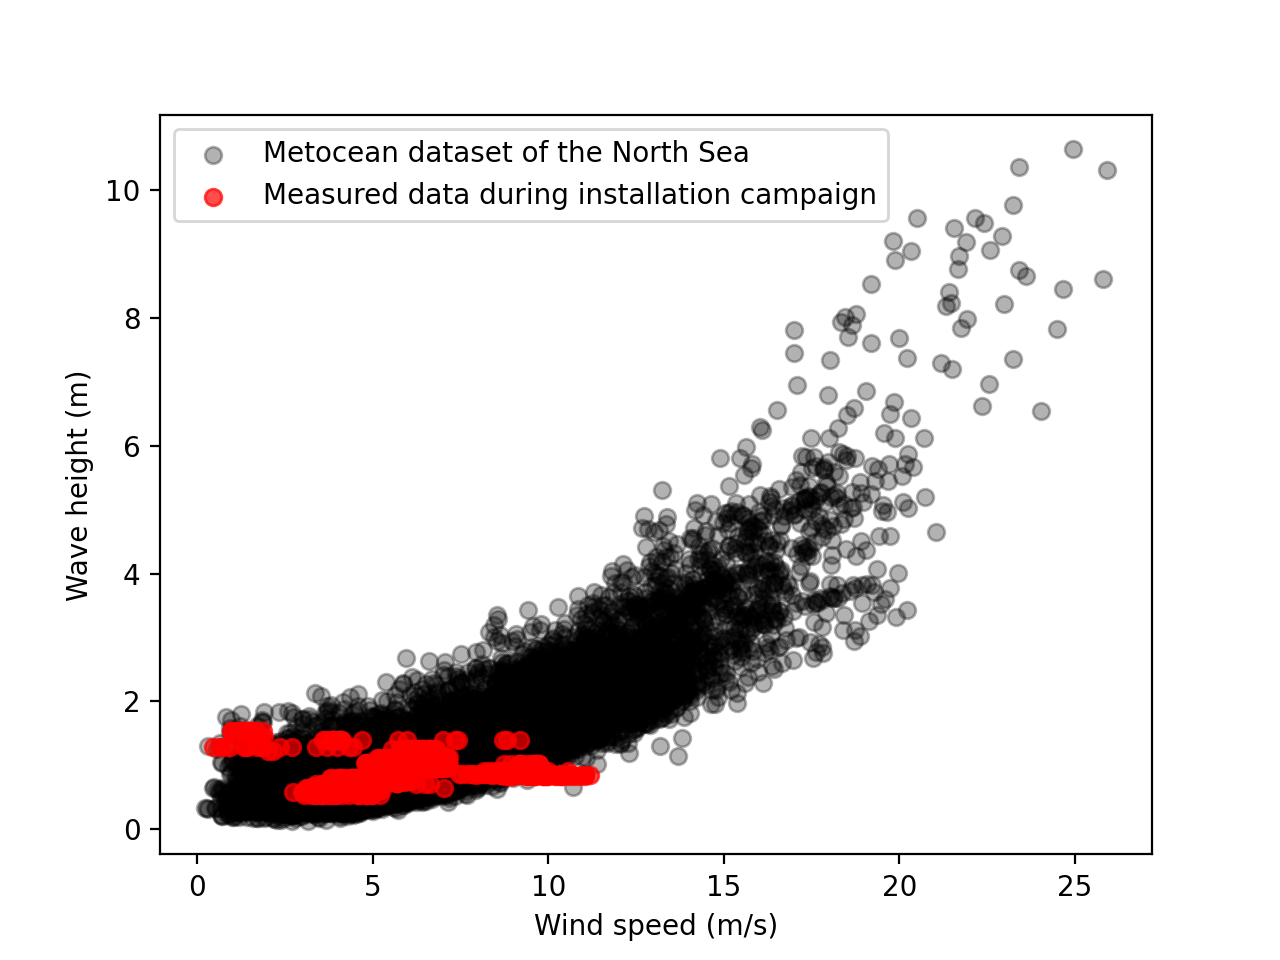

In [8]:
# correlation between wind speed and wave height

plt.figure()
plt.scatter(dataset_D.wind_speed,dataset_D.wave_height, color='k', alpha=0.3, label='Metocean dataset of the North Sea')
plt.scatter(data.windSpeed,data.waveHeight, color='r', alpha=0.7, label='Measured data during installation campaign')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Wave height (m)')
plt.legend()

# SBIT RESPONSE EMULATOR

# Distributions

In [9]:
# set up the histogramm, 60 steps= bin size of 0,5 cm deflection
bins = np.linspace(0, 30, 60)
bin_centers = 0.5*(bins[1:] + bins[:-1])

# fit GEV and weibull distribution to data
gev_fit = stats.genextreme.fit(data.peakDeflectionSBIT)
gev_pdf= stats.genextreme.pdf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])
gev_ppf= stats.genextreme.ppf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])
gev_cdf= stats.genextreme.cdf(bin_centers, gev_fit[0], loc= gev_fit[1], scale= gev_fit[2])

print(gev_fit)

(-0.1280961498390108, 1.7931853339550328, 0.7194948859860504)


<IPython.core.display.Javascript object>


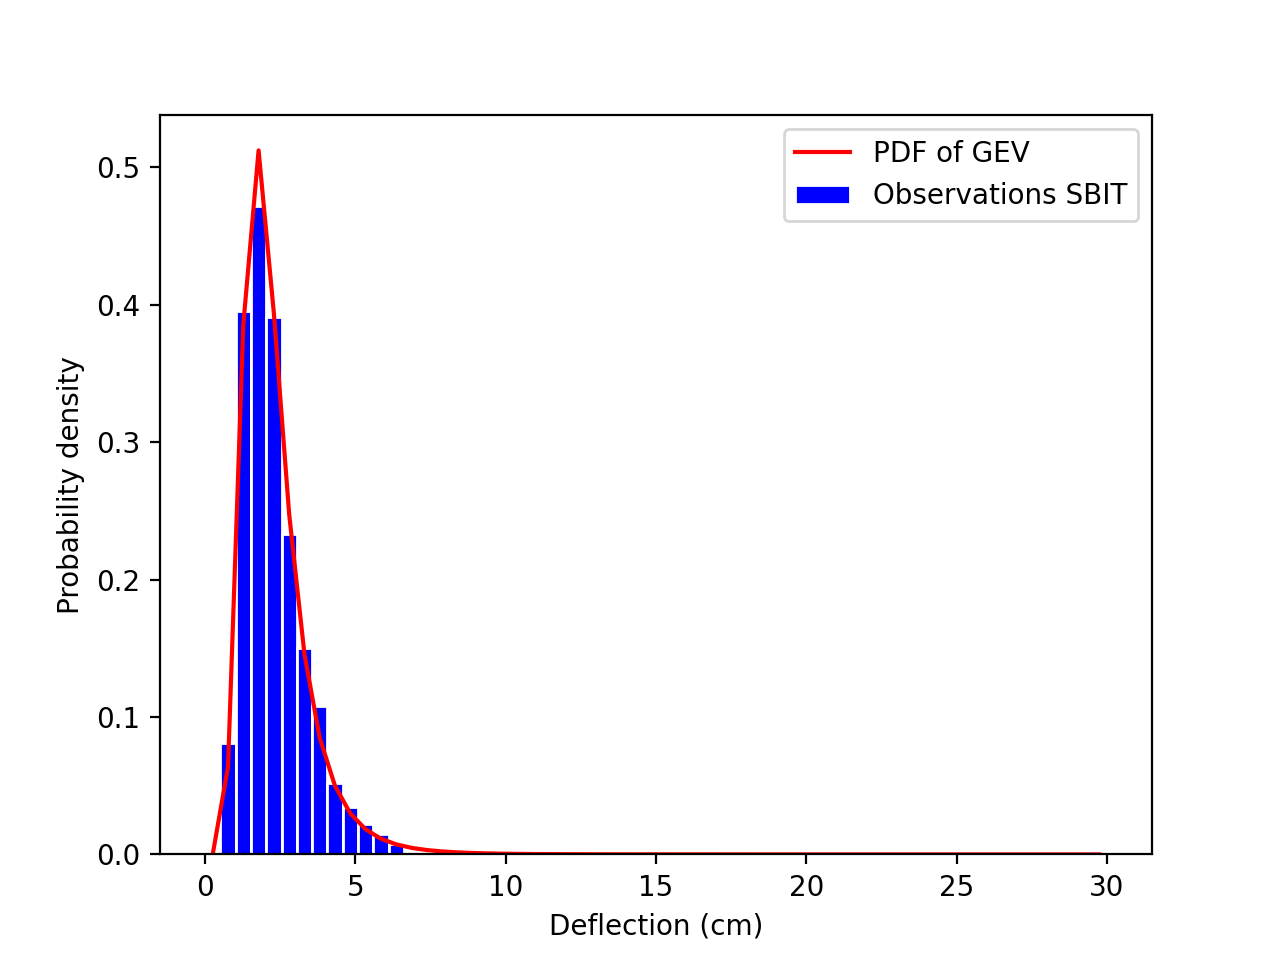

In [10]:
fig, ax1 = plt.subplots()

ax1.hist(data.peakDeflectionSBIT, bins=bins, label='Observations SBIT', color='blue', density= 'true', stacked='true', edgecolor='w')
ax1.plot(bin_centers, gev_pdf, label="PDF of GEV", color='r')
ax1.set_xlabel('Deflection (cm)')
ax1.set_ylabel('Probability density')

ax1.legend()

plt.show()

<IPython.core.display.Javascript object>


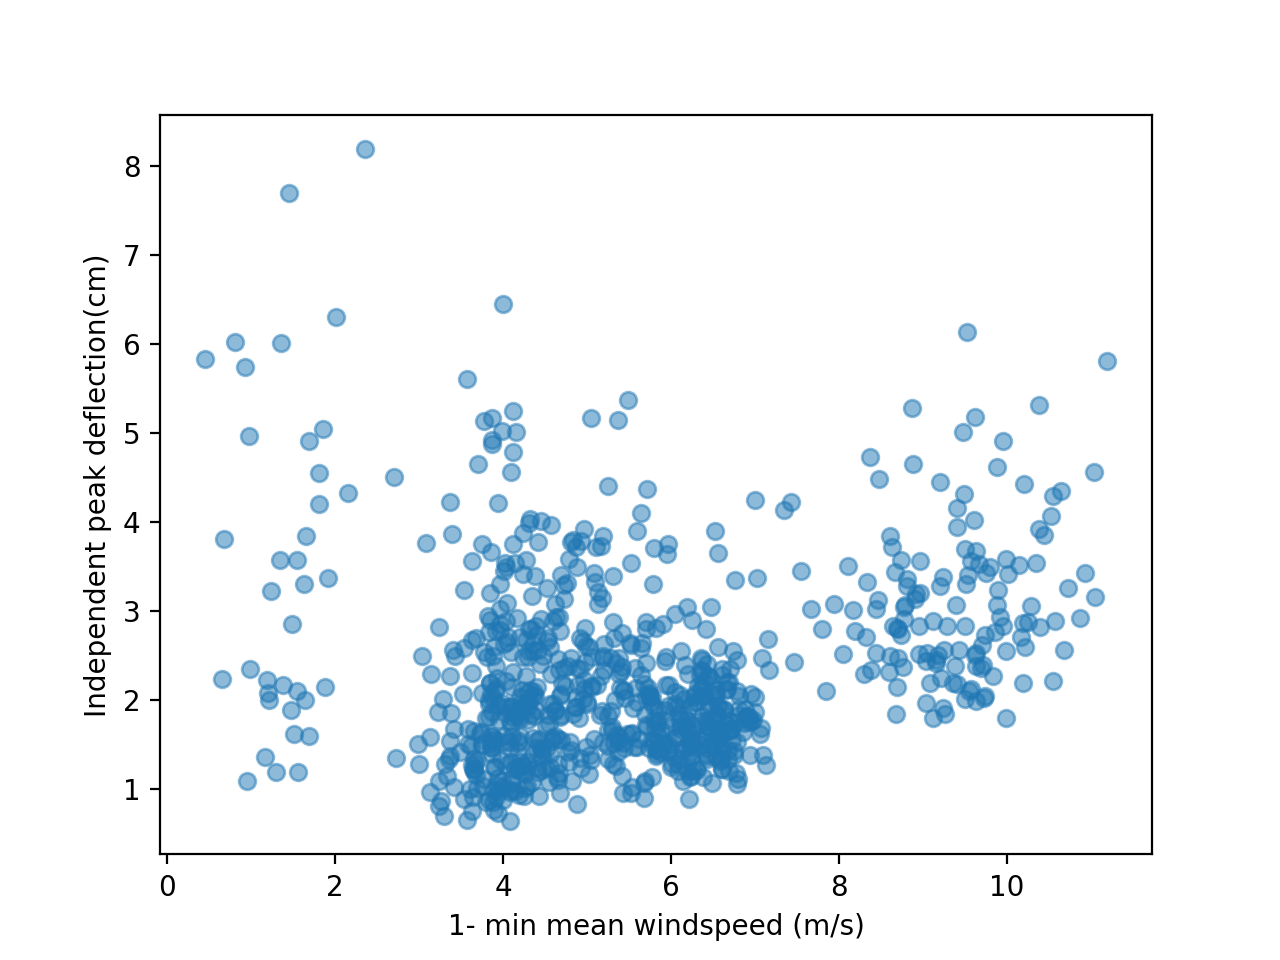

Text(0, 0.5, 'Independent peak deflection(cm)')

In [11]:
fig, ax1 = plt.subplots(1)
ax1.scatter(data.windSpeed, data.peakDeflectionSBIT, alpha= 0.5)
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')

<IPython.core.display.Javascript object>


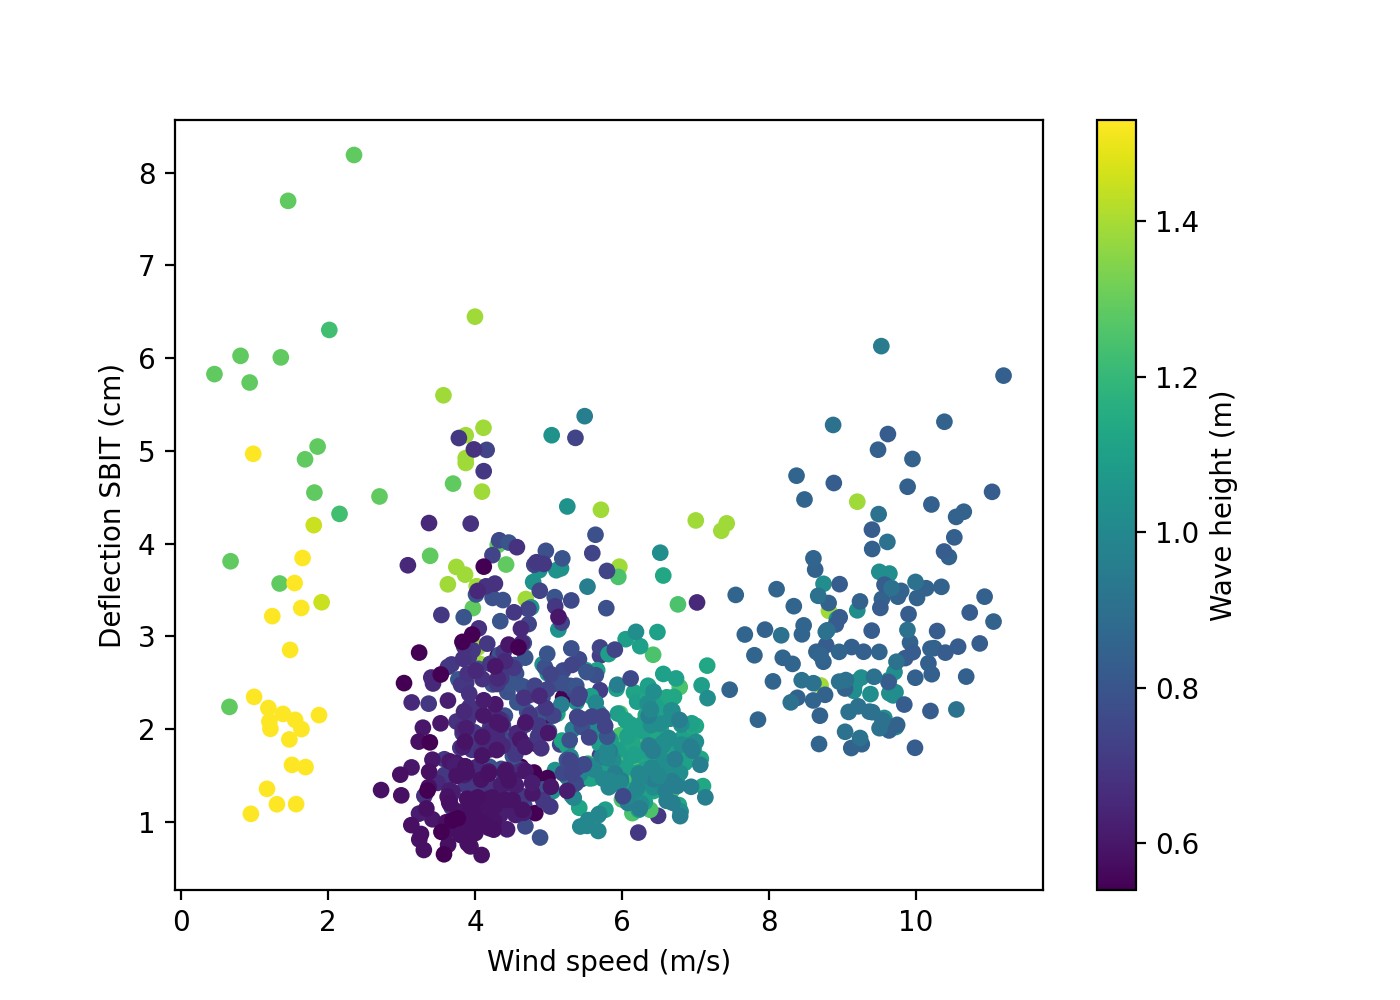

Text(0, 0.5, 'Deflection SBIT (cm)')

In [12]:
fig = plt.figure(figsize= (7,5))
plt.scatter(data.windSpeed, data.peakDeflectionSBIT,edgecolors='none',c= data.waveHeight)
cbar= plt.colorbar()
cbar.set_label('Wave height (m)')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Deflection SBIT (cm)')

In [13]:
data.corr()

windSpeed  waveHeight    waveTp    waveTz  \
windSpeed             1.000000    0.077811 -0.128155 -0.178240   
waveHeight            0.077811    1.000000  0.826796  0.874009   
waveTp               -0.128155    0.826796  1.000000  0.940959   
waveTz               -0.178240    0.874009  0.940959  1.000000   
peakDeflectionSBIT    0.147795    0.246625  0.130200  0.227835   
peakDeflectionTower   0.204713    0.096135  0.042690  0.030987   

                     peakDeflectionSBIT  peakDeflectionTower  
windSpeed                      0.147795             0.204713  
waveHeight                     0.246625             0.096135  
waveTp                         0.130200             0.042690  
waveTz                         0.227835             0.030987  
peakDeflectionSBIT             1.000000             0.094591  
peakDeflectionTower            0.094591             1.000000

In [14]:
data2= data.drop(['waveTp', 'waveTz'], axis=1)

<IPython.core.display.Javascript object>


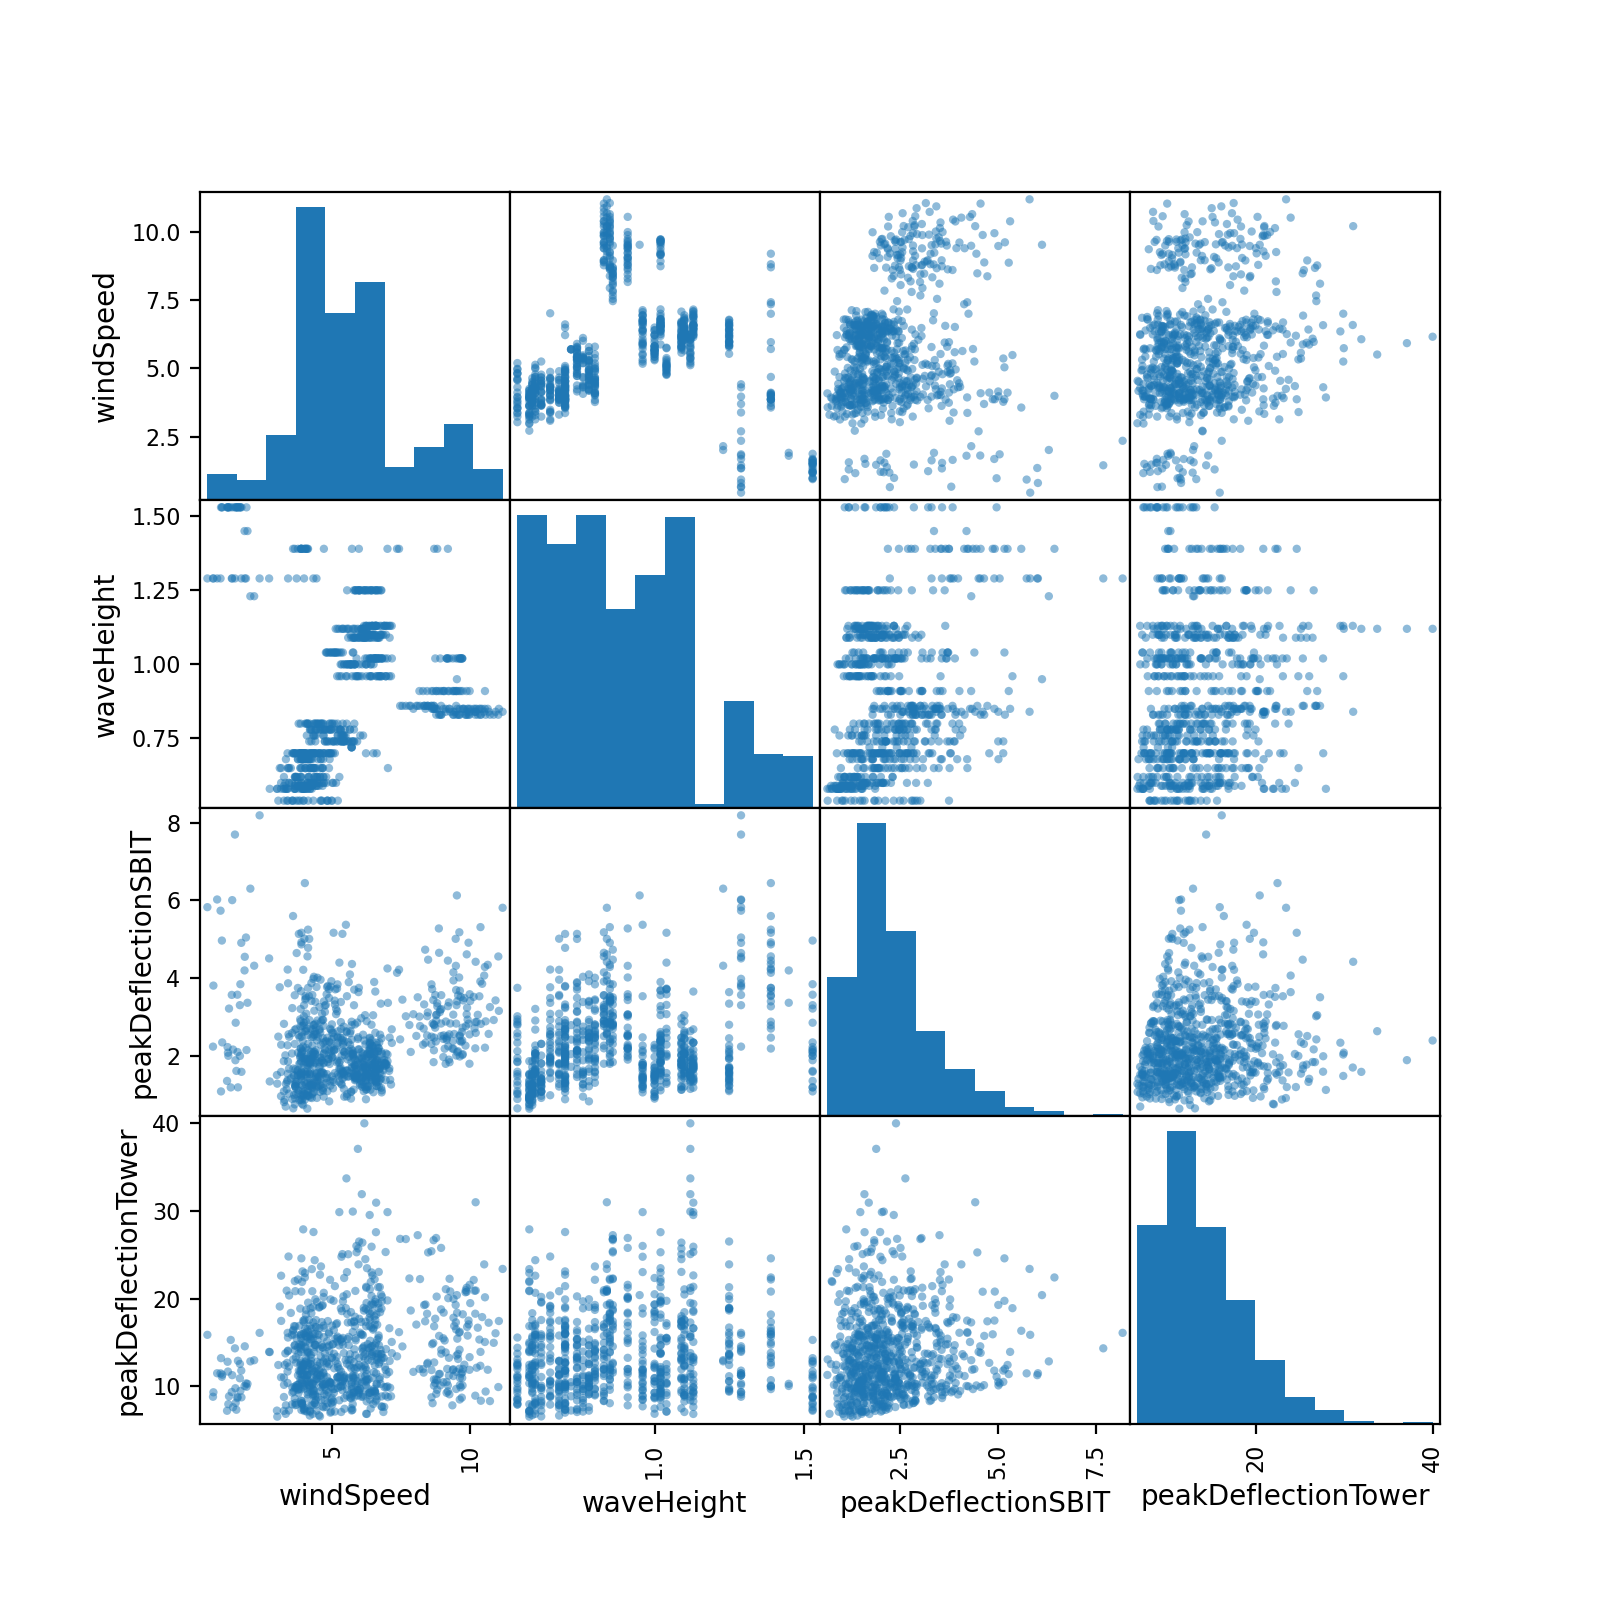

array([[<AxesSubplot:xlabel='windSpeed', ylabel='windSpeed'>,
        <AxesSubplot:xlabel='waveHeight', ylabel='windSpeed'>,
        <AxesSubplot:xlabel='peakDeflectionSBIT', ylabel='windSpeed'>,
        <AxesSubplot:xlabel='peakDeflectionTower', ylabel='windSpeed'>],
       [<AxesSubplot:xlabel='windSpeed', ylabel='waveHeight'>,
        <AxesSubplot:xlabel='waveHeight', ylabel='waveHeight'>,
        <AxesSubplot:xlabel='peakDeflectionSBIT', ylabel='waveHeight'>,
        <AxesSubplot:xlabel='peakDeflectionTower', ylabel='waveHeight'>],
       [<AxesSubplot:xlabel='windSpeed', ylabel='peakDeflectionSBIT'>,
        <AxesSubplot:xlabel='waveHeight', ylabel='peakDeflectionSBIT'>,
        <AxesSubplot:xlabel='peakDeflectionSBIT', ylabel='peakDeflectionSBIT'>,
        <AxesSubplot:xlabel='peakDeflectionTower', ylabel='peakDeflectionSBIT'>],
       [<AxesSubplot:xlabel='windSpeed', ylabel='peakDeflectionTower'>,
        <AxesSubplot:xlabel='waveHeight', ylabel='peakDeflectionTower'>,
        

In [15]:
pd.plotting.scatter_matrix(data2, figsize=(8,8))

## GEV Fit

<IPython.core.display.Javascript object>


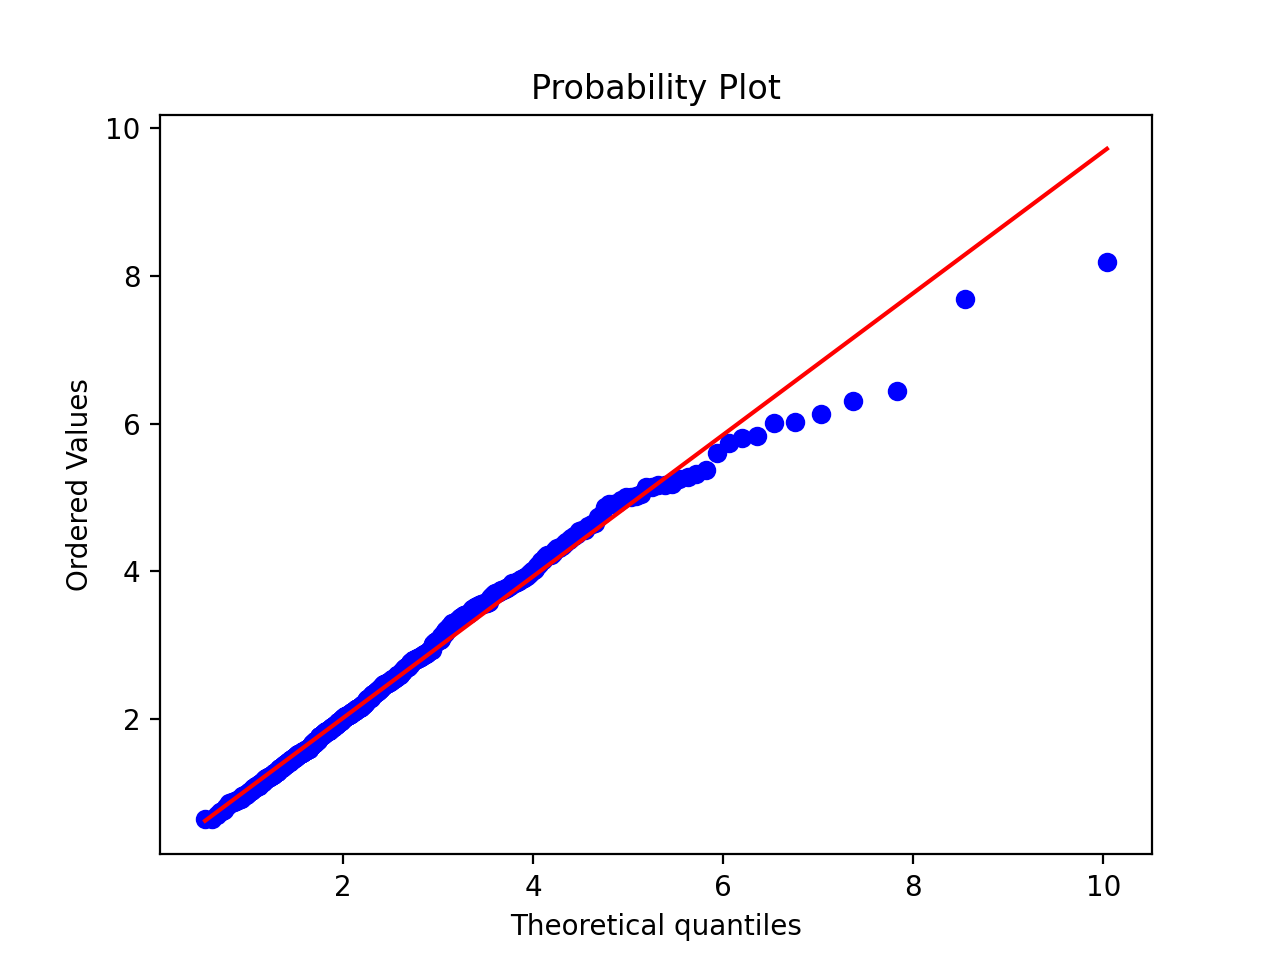

In [16]:
plt.figure()
stats.probplot(data.peakDeflectionSBIT, (gev_fit[0], gev_fit[1], gev_fit[2]), dist='genextreme', plot=pylab)
pylab.show()

# Intervals

In [17]:
# Slice the data set of deflection into intervals of the wind speed.

width_slicer_V = WidthOfIntervalSlicer(width=1, reference="right", min_n_points=1)
wind_slices, wind_references, wind_boundaries = width_slicer_V.slice_(data.windSpeed)

deflection_intervals= []
for i in range (len(wind_references)):
    deflection_intervals.append([])


for i in range(len(wind_slices)):
    for j in range(len(wind_slices[i])):
        if (data.windSpeed[j] >= wind_boundaries[i][0]) & (data.windSpeed[j] < wind_boundaries[i][1]):
            deflection_intervals[i].append(data.peakDeflectionSBIT[j])

In [18]:
parameter_list= []
for i in range (len(gev_fit)):
    parameter_list.append([])

for i in range(len(deflection_intervals)):
    fit= stats.genextreme.fit(deflection_intervals[i])
    parameter_list[0].append(fit[0])
    parameter_list[1].append(fit[1])
    parameter_list[2].append(fit[2])


11


In [19]:
# shape parameter
mean= np.mean(parameter_list[0])

-0.11472415007115067


<IPython.core.display.Javascript object>


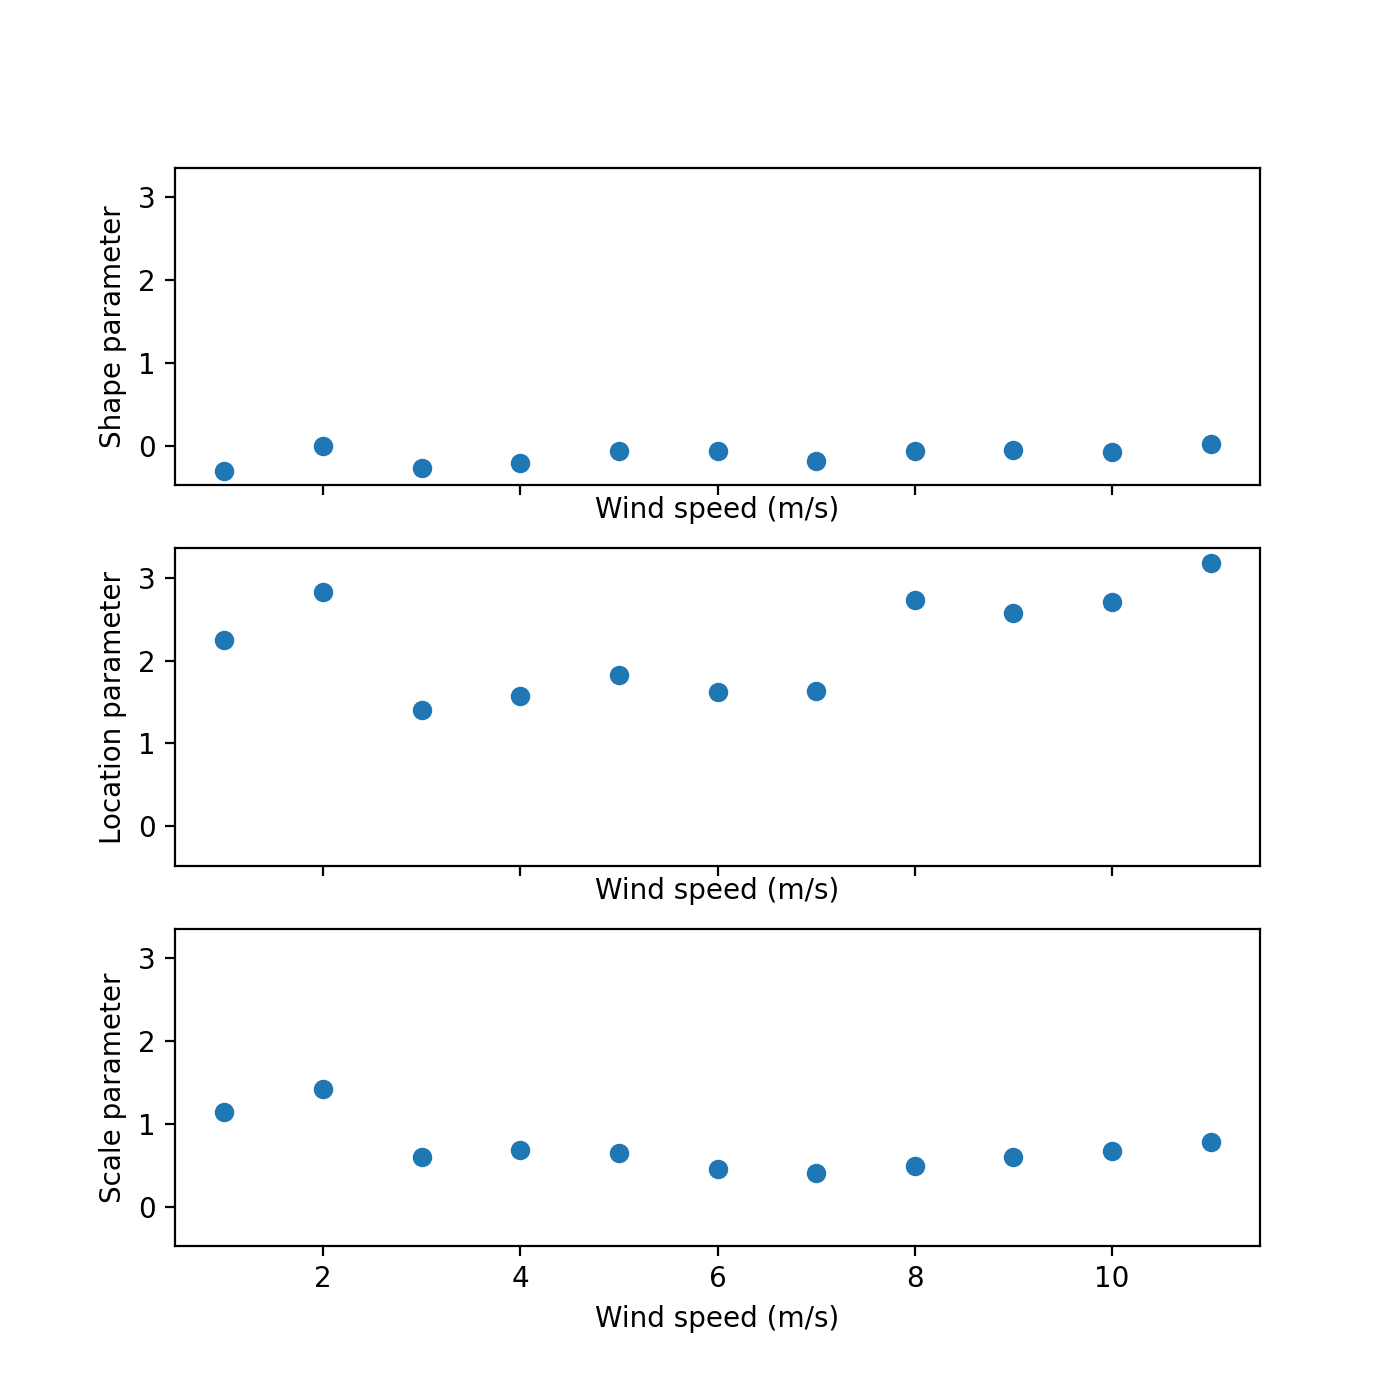

Text(0, 0.5, 'Scale parameter')

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=True, sharex= True, figsize=(7,7))
ax1.scatter(wind_references, parameter_list[0])
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(wind_references, parameter_list[1])
ax2.set_xlabel('Wind speed (m/s)')
ax2.set_ylabel('Location parameter')
ax3.scatter(wind_references, parameter_list[2])
ax3.set_xlabel('Wind speed (m/s)')
ax3.set_ylabel('Scale parameter')

In [21]:
# WIND

r_shape_wind = np.corrcoef(parameter_list[0], wind_references)
r_location_wind = np.corrcoef(parameter_list[1], wind_references)
r_scale_wind = np.corrcoef(parameter_list[2], wind_references)
print(r_shape_wind)
print(r_location_wind)
print(r_scale_wind)

[[1.         0.59743541]
 [0.59743541 1.        ]]
[[1.         0.47638591]
 [0.47638591 1.        ]]
[[ 1.         -0.53373724]
 [-0.53373724  1.        ]]


# Dependence function of response

In [22]:
# Define dependence functions

def _power3(x, a, b, c):
    return a + b * x ** c
def _linear(x, a, b):
    return x * a + b
def _exp3(x, a, b, c):
    return a + b * np.exp(c * x)


bounds_3p = [(None, None), (None, None), (None, None)]
bounds_2p = [(None, None), (None, None)]
exp_bounds = [(0, None), (0, None), (None, None)]

power3 = DependenceFunction(_power3, bounds_3p, latex="$a + b * x^c$")
linear = DependenceFunction(_linear, latex="$a + b * x$")
exp3 = DependenceFunction(_exp3, bounds=exp_bounds)

#print(tuple(exp3.parameters.values()))
#print(tuple(linear.parameters.values()))
#print(tuple(power3.parameters.values()))

In [23]:
shape_param_fit= linear.fit(wind_references, parameter_list[0])
print(shape_param_fit)

#linear.fit(wind_references, parameter_list[0])
#print(linear)

None


In [24]:
x= np.asarray(wind_references)
y1= np.asarray(parameter_list[0]) #shape
y2= np.asarray(parameter_list[1]) #location
y3= np.asarray(parameter_list[2]) #scale

## linear fit

In [25]:
my_linear_param1 = fit_function(linear, x, y1, (1, 1), "lsq", None, None)
my_linear_param2 = fit_function(linear, x, y2, (1, 1), "lsq", None, None)
my_linear_param3 = fit_function(linear, x, y3, (1, 1), "lsq", None, None)
print(my_linear_param1)
print(my_linear_param2)
print(my_linear_param3)

[ 0.01917579 -0.2297789 ]
[0.08919855 1.67636924]
[-0.04915738  1.01615747]


<IPython.core.display.Javascript object>


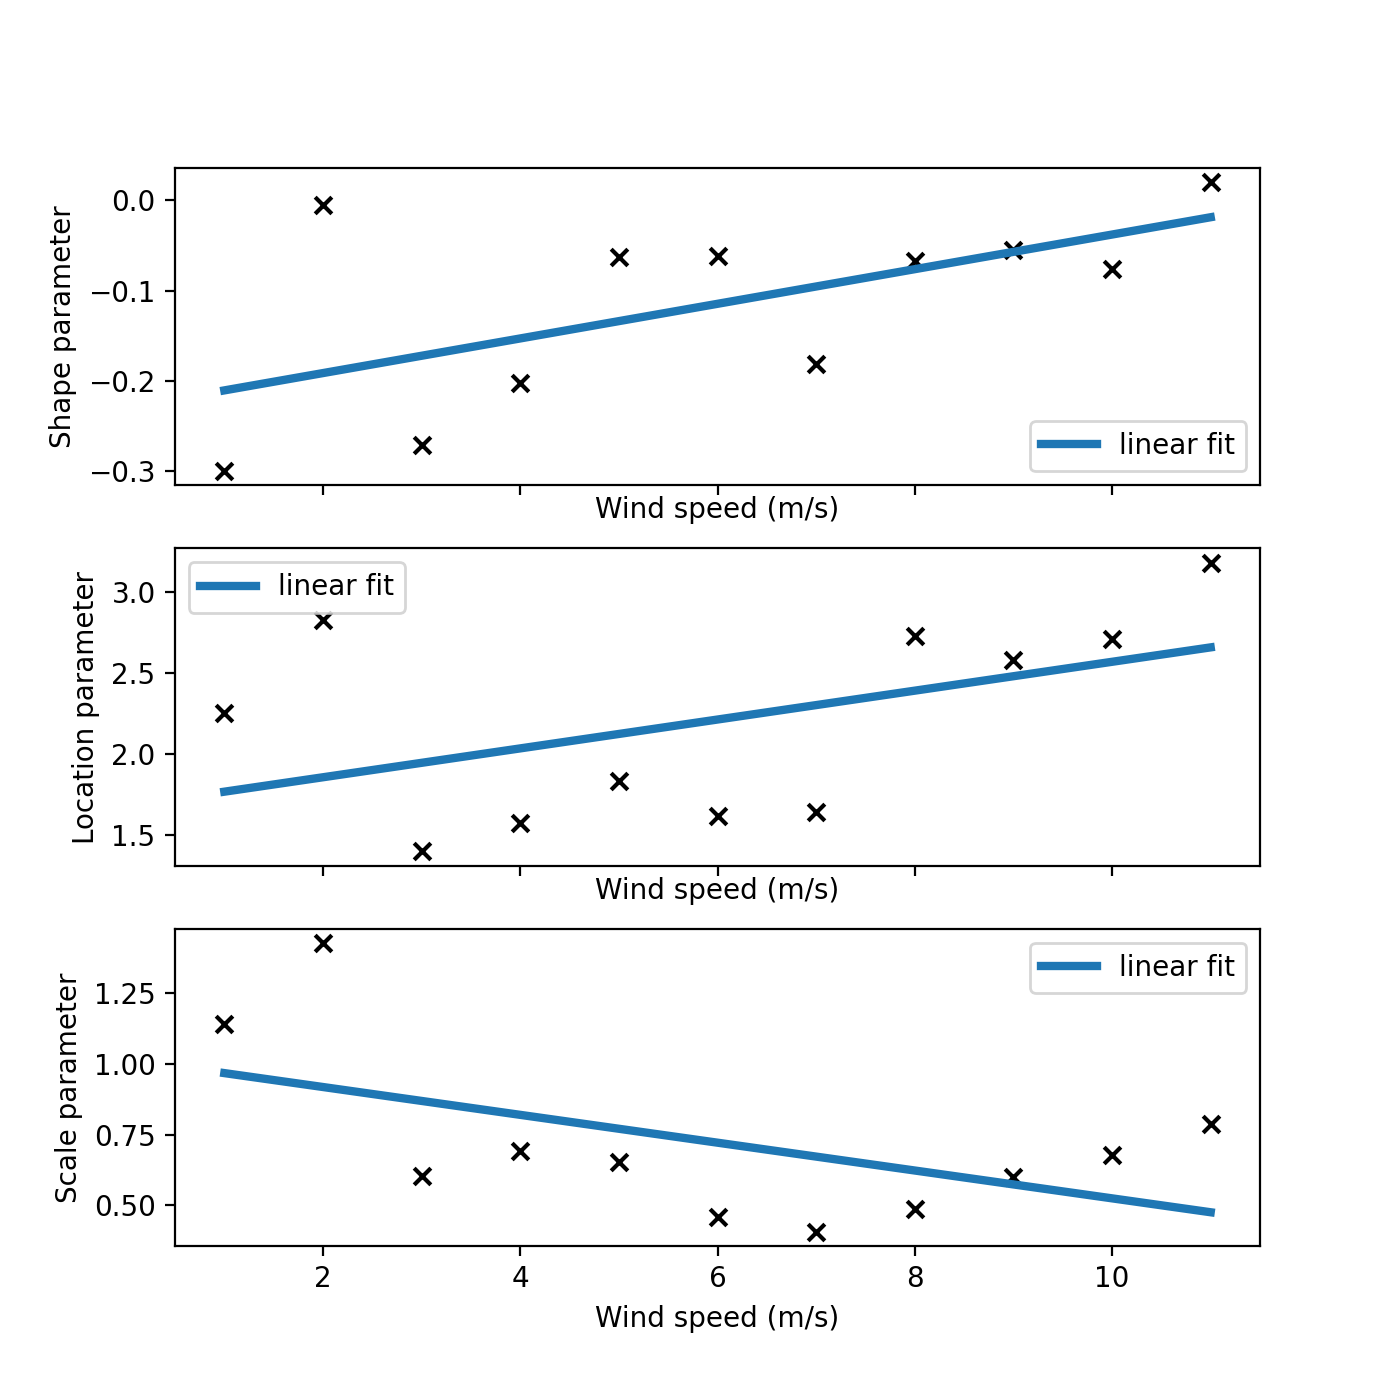

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex= True, figsize=(7,7))
ax1.scatter(x, y1, marker="x", c="k")
ax1.plot(x, linear(x, *my_linear_param1), label="linear fit", linewidth=3)
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Shape parameter')
ax2.scatter(x, y2, marker="x", c="k")
ax2.plot(x, linear(x, *my_linear_param2), label="linear fit", linewidth=3)
ax2.set_xlabel('Wind speed (m/s)')
ax2.set_ylabel('Location parameter')
ax3.scatter(x, y3, marker="x", c="k")
ax3.plot(x, linear(x, *my_linear_param3), label="linear fit", linewidth=3)
ax3.set_xlabel('Wind speed (m/s)')
ax3.set_ylabel('Scale parameter')

ax1.legend()
ax2.legend()
ax3.legend()

<IPython.core.display.Javascript object>


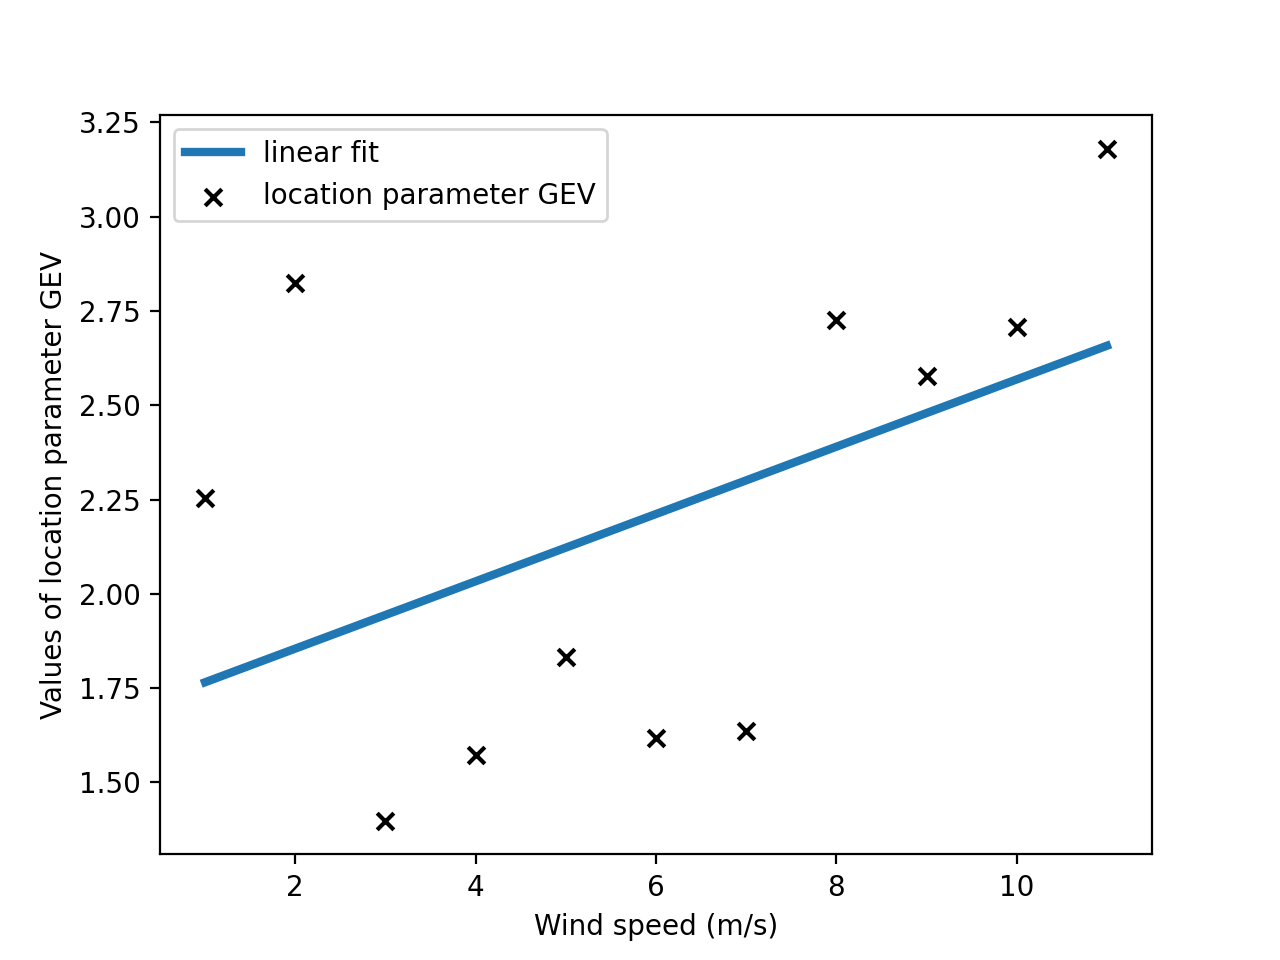

In [27]:
plt.figure()
plt.scatter(x, y2, marker="x", c="k", label= 'location parameter GEV')
plt.plot(x, linear(x, *my_linear_param2), label="linear fit", linewidth=3)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Values of location parameter GEV')
plt.legend()

# Alternative Dependency

In [28]:
#mean_absolute_error(data.deflection,)
#Korrelationskoeffizient
# Intervall von 0-2 anschauen, Maxima anschauen

# Mean deflection per interval
mean_deflection = []
for i in range(len(wind_references)):
    mean_deflection.append(np.mean(deflection_intervals[i]))

# Min deflection per interval
min_deflection = []
for i in range(len(wind_references)):
    min_deflection.append(min(deflection_intervals[i]))
    
# Max deflection per interval
max_deflection = []
for i in range(len(wind_references)):
    max_deflection.append(max(deflection_intervals[i]))
    
r_min = np.corrcoef(min_deflection, wind_references)
r_max = np.corrcoef(max_deflection, wind_references)
r_mean = np.corrcoef(mean_deflection, wind_references)
print(r_min)
print(r_mean)
print(r_max)

[[1.         0.76440649]
 [0.76440649 1.        ]]
[[1.         0.18594993]
 [0.18594993 1.        ]]
[[ 1.         -0.45415571]
 [-0.45415571  1.        ]]


In [29]:
my_linear_param_min = fit_function(linear, x, min_deflection, (1, 1), "lsq", None, None)
print(my_linear_param_min)

[0.13182091 0.50983818]


<IPython.core.display.Javascript object>


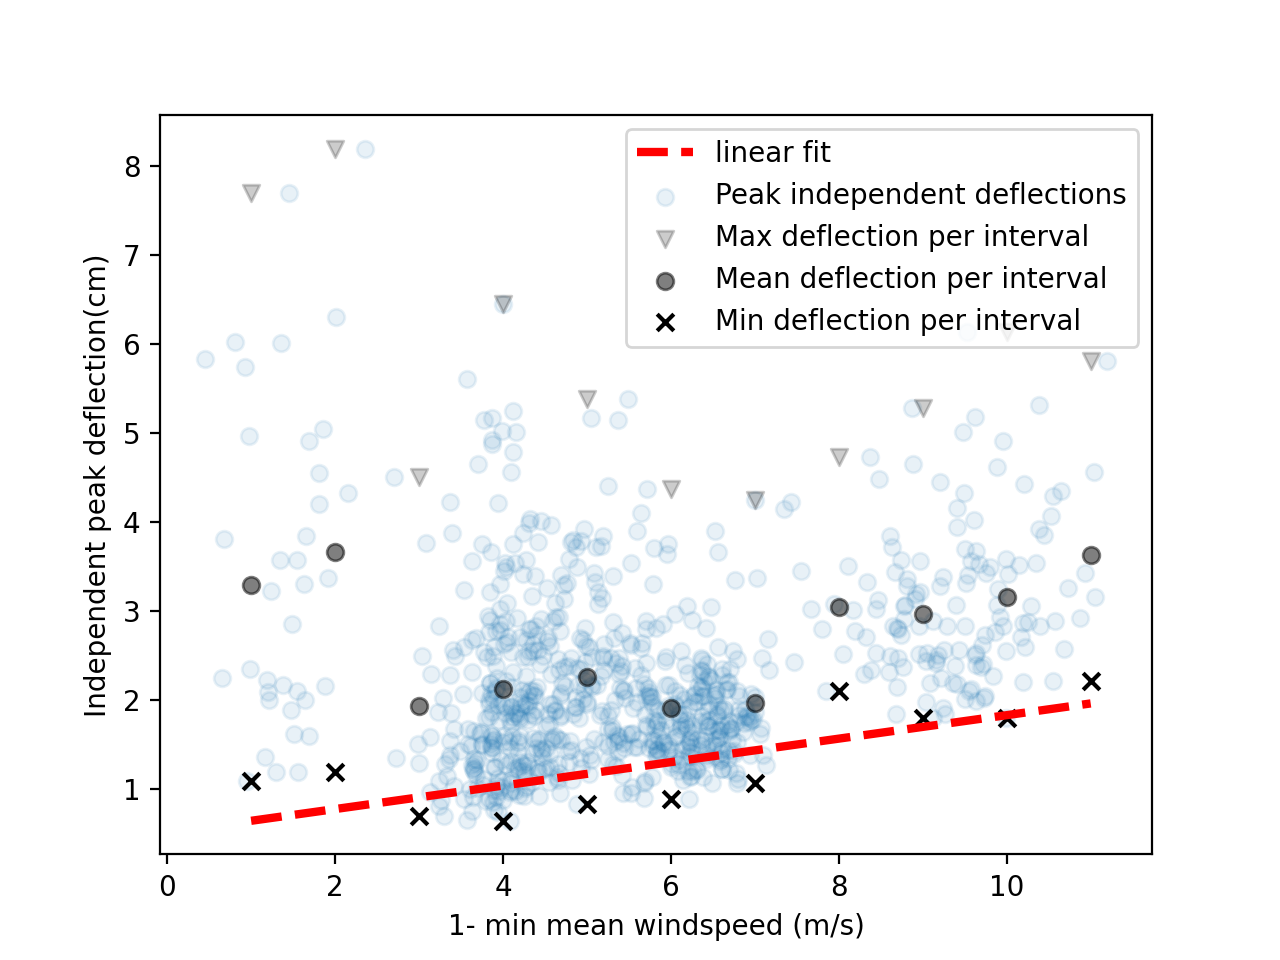

In [30]:
fig, ax1 = plt.subplots(1)
ax1.scatter(data.windSpeed, data.peakDeflectionSBIT, alpha= 0.1, label='Peak independent deflections')
ax1.scatter(wind_references, max_deflection, marker="v", c="k",alpha=0.2, label='Max deflection per interval')
ax1.scatter(wind_references, mean_deflection, marker="o", c="k",alpha=0.5, label='Mean deflection per interval')
ax1.scatter(wind_references, min_deflection, marker="x", c="k", label='Min deflection per interval')
ax1.plot(x, linear(x, *my_linear_param_min), linestyle='--', color= 'r',label="linear fit", linewidth=3)
ax1.set_xlabel('1- min mean windspeed (m/s)')
ax1.set_ylabel('Independent peak deflection(cm)')
ax1.legend()

# Modell 1: R

In [31]:
dist_R= stats.genextreme(gev_fit[0], gev_fit[1], gev_fit[2])
rvs= dist_R.rvs(size=800)

In [32]:
peak_defl_SBIT= pd.DataFrame.to_numpy(data.peakDeflectionSBIT)
model_error= peak_defl_SBIT-rvs
model_error= abs(model_error)

model_error_mean= np.nanmean(model_error)
print(model_error_mean)
print(min(data.peakDeflectionSBIT))
print(max(data.peakDeflectionSBIT))

1.1602632057790874
0.6434
8.1888


<IPython.core.display.Javascript object>


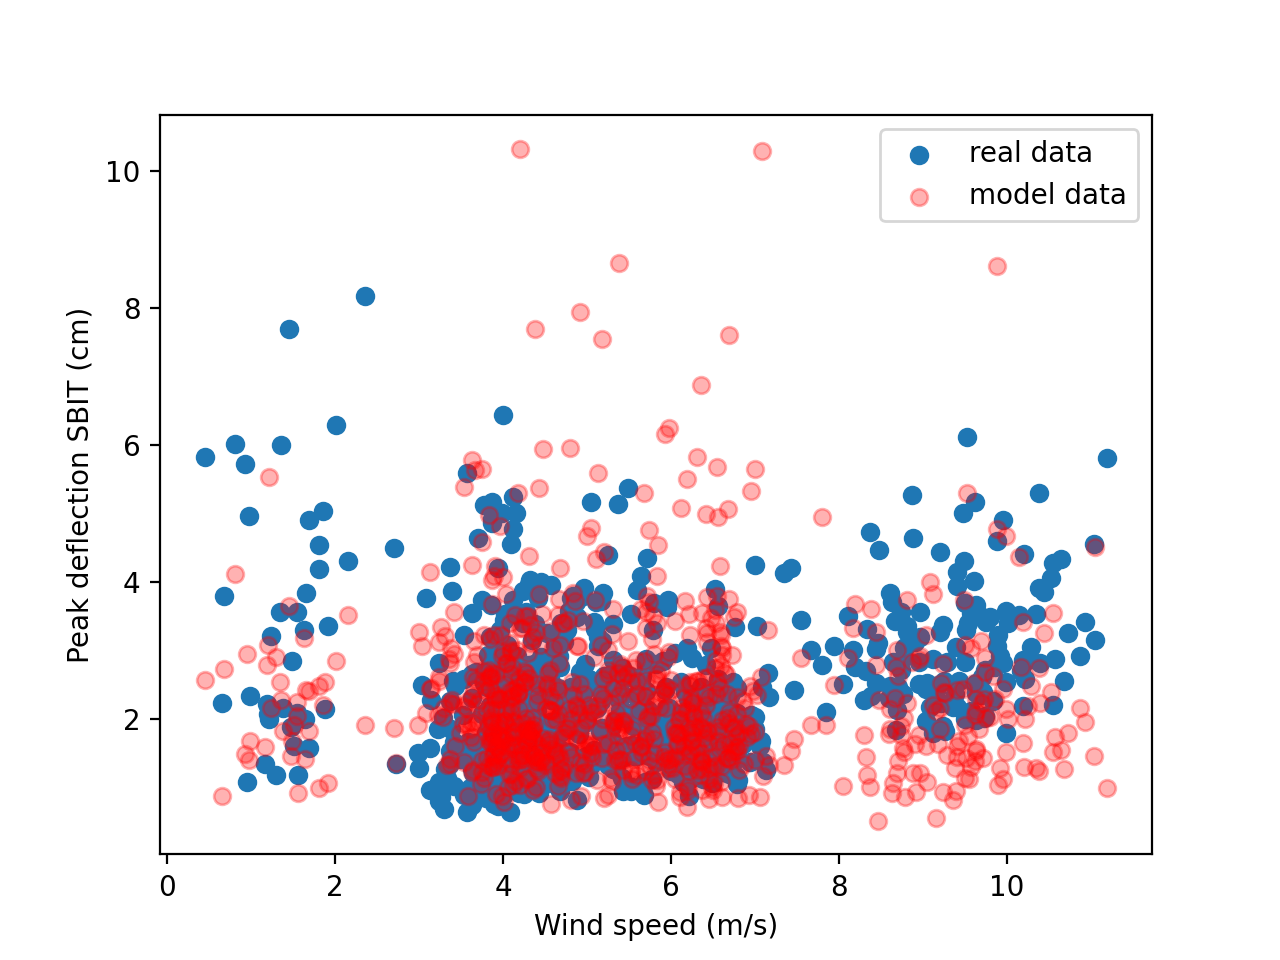

In [33]:
plt.figure()
plt.scatter(data.windSpeed, data.peakDeflectionSBIT, label='real data')
plt.scatter(data.windSpeed, rvs, alpha=0.3, color= 'r', label='model data')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Peak deflection SBIT (cm)')
plt.legend()

# Modell 2: R(V)

In [35]:
def mu_func(v):
    return 0.089*v +1.676
def sigma_func(v):
    return -0.049*v +1.016

In [37]:
mu= mu_func(data.windSpeed)
sigma= sigma_func(data.windSpeed)

In [38]:
con_dist_V= stats.genextreme(gev_fit[0], mu, gev_fit[2])
rvs2D= con_dist_V.rvs(size=800)

In [39]:
peak_defl_SBIT= pd.DataFrame.to_numpy(data.peakDeflectionSBIT)
model_error2D= peak_defl_SBIT-rvs2D
model_error2D= abs(model_error2D)

model_error2D_mean= np.nanmean(model_error2D)
print(model_error2D_mean)

1.1748757928167164


## Comparison real data and model

<IPython.core.display.Javascript object>


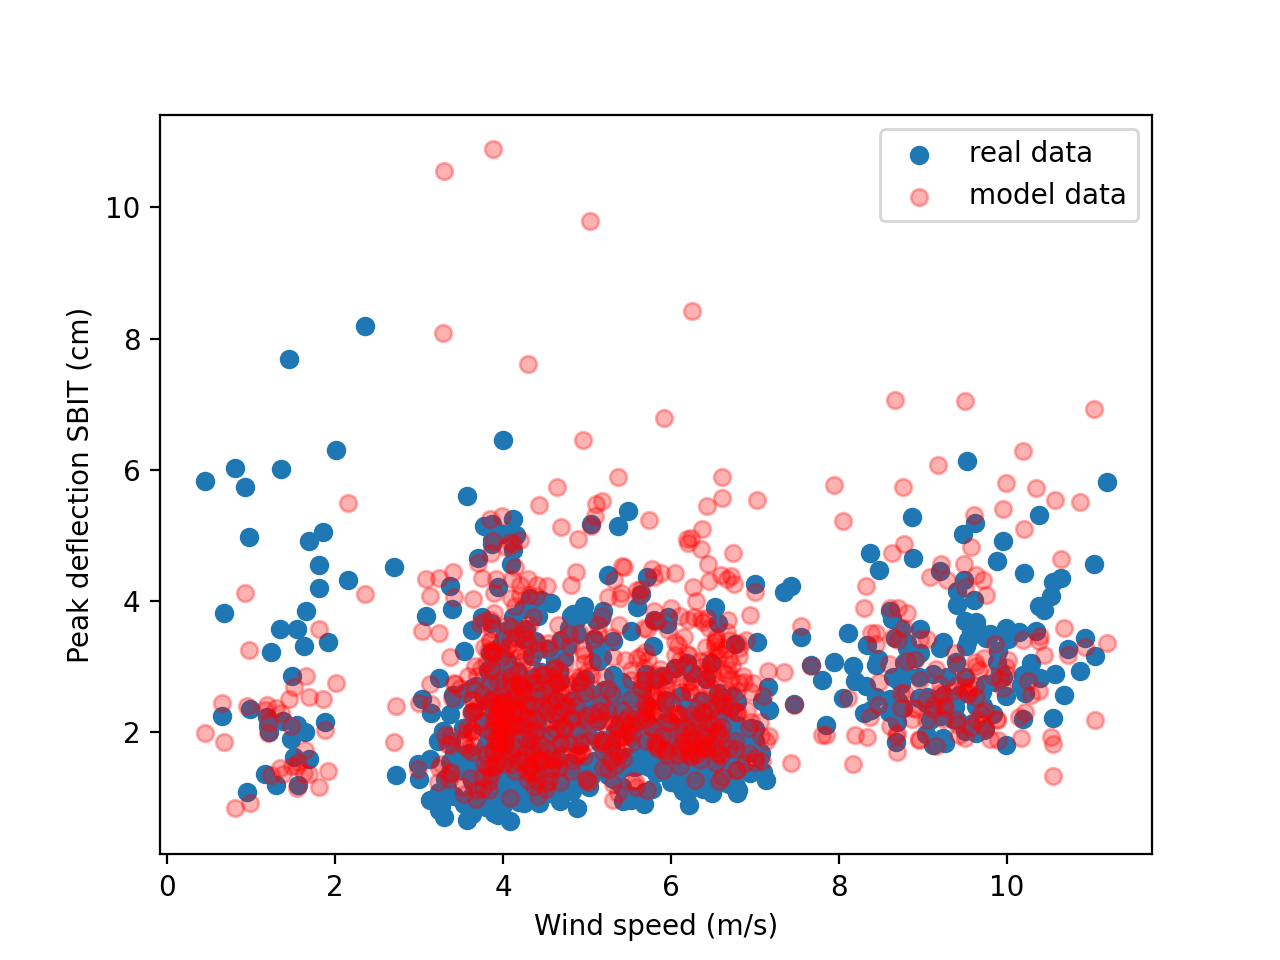

In [40]:
plt.figure()
plt.scatter(data.windSpeed, data.peakDeflectionSBIT, label='real data')
plt.scatter(data.windSpeed, rvs2D, alpha=0.3, color= 'r', label='model data')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Peak deflection SBIT (cm)')
plt.legend()

## Quantile Plots- Goodness of fit

In [42]:
intervals_V_1Dmodel= []
for i in range (len(wind_references)):
    intervals_V_1Dmodel.append([])


for i in range(len(wind_slices)):
    for j in range(len(wind_slices[i])):
        if (data.windSpeed[j] >= wind_boundaries[i][0]) & (data.windSpeed[j] < wind_boundaries[i][1]):
            intervals_V_1Dmodel[i].append(rvs[j])

intervals_V_2Dmodel= []
for i in range (len(wind_references)):
    intervals_V_2Dmodel.append([])
    
for i in range(len(wind_slices)):
    for j in range(len(wind_slices[i])):
        if (data.windSpeed[j] >= wind_boundaries[i][0]) & (data.windSpeed[j] < wind_boundaries[i][1]):
            intervals_V_2Dmodel[i].append(rvs2D[j])

In [43]:
# discrete quantiles 

quantile10_data= []
quantile50_data= []
quantile90_data= []
quantile99_data= []

quantile10_model1D= []
quantile50_model1D= []
quantile90_model1D= []
quantile99_model1D= []

quantile10_model2D= []
quantile50_model2D= []
quantile90_model2D= []
quantile99_model2D= []

for i in range (len(deflection_intervals)):
    quantile10_data.append(np.quantile(deflection_intervals[i], 0.10))
    quantile50_data.append(np.quantile(deflection_intervals[i], 0.50))
    quantile90_data.append(np.quantile(deflection_intervals[i], 0.90))
    quantile99_data.append(np.quantile(deflection_intervals[i], 0.99))
    
for i in range (len(intervals_V_1Dmodel)):
    quantile10_model1D.append(np.quantile(intervals_V_1Dmodel[i], 0.10))
    quantile50_model1D.append(np.quantile(intervals_V_1Dmodel[i], 0.50))
    quantile90_model1D.append(np.quantile(intervals_V_1Dmodel[i], 0.90))
    quantile99_model1D.append(np.quantile(intervals_V_1Dmodel[i], 0.99))
    
for i in range (len(intervals_V_2Dmodel)):
    quantile10_model2D.append(np.quantile(intervals_V_2Dmodel[i], 0.10))
    quantile50_model2D.append(np.quantile(intervals_V_2Dmodel[i], 0.50))
    quantile90_model2D.append(np.quantile(intervals_V_2Dmodel[i], 0.90))
    quantile99_model2D.append(np.quantile(intervals_V_2Dmodel[i], 0.99))

In [44]:
print(quantile10_data)
print(quantile50_data)
print(quantile90_data)

[1.3232000000000002, 1.60522, 0.95596, 1.0116, 1.27946, 1.22255, 1.33495, 2.32335, 2.1525, 2.0915000000000004, 2.59868]
[2.3479, 3.5747, 1.56405, 1.8636, 2.1111, 1.7703000000000002, 1.8075999999999999, 3.0157499999999997, 2.8331, 2.90355, 3.3426]
[6.01066, 5.548940000000001, 3.77679, 3.5689, 3.46432, 2.776790000000001, 2.5903500000000004, 3.7988700000000004, 4.108760000000001, 4.44072, 4.53666]


In [45]:
print(quantile10_model1D)
print(quantile50_model1D)
print(quantile90_model1D)

[1.4531525995404295, 1.04221662230749, 1.41858527480757, 1.297161304732362, 1.2365161568396839, 1.1839313659671653, 1.3145173733052118, 1.0257499926729787, 0.9501018885152251, 1.2825811602807287, 1.299586253152547]
[2.281005829186534, 2.204682773231186, 2.3683025307941583, 1.9742093486728727, 2.008871266520452, 2.0051574237371392, 1.968886510748097, 2.396433474021922, 1.8560276545701981, 2.138488530058736, 1.7676613165424178]
[3.7530687313829736, 2.9891192885548747, 3.2814345613504012, 3.53971580574734, 3.573006812438649, 3.56685351632954, 3.7995638548607062, 3.6361164865158426, 3.0010549224142773, 3.511726258634911, 3.4427116656147727]


In [46]:
print(quantile10_model2D)
print(quantile50_model2D)
print(quantile90_model2D)

[1.2528788248922567, 1.2823922906843457, 1.3802120356437289, 1.4614271037096453, 1.4620390645825596, 1.7341633463555393, 1.5647959843443995, 1.9398788141697239, 1.9533475783722605, 2.0720740178658694, 1.820230990534651]
[2.1539284172485824, 2.031392149509898, 2.4819480025984486, 2.4109123385796347, 2.3195930575196764, 2.579081068722284, 2.6035942908824374, 2.888168292449021, 2.668588013420649, 2.8376435052556954, 3.3210906347642126]
[2.648581433230278, 3.783154236726554, 4.356699191774155, 4.081788116478501, 4.228995404173995, 4.176767073661137, 4.1022090762144625, 4.521277587504219, 4.566159497240647, 5.316896307215628, 5.538999399177653]


In [47]:
# calculate mean absolute error of 2D and 3D model in comparison to quantiles of real data

mae_model1D_10= []
mae_model1D_50= []
mae_model1D_90= []

mae_model2D_10= []
mae_model2D_50= []
mae_model2D_90= []

for i in range(len(quantile10_model2D)):
    mae_model1D_10.append(abs(quantile10_data[i]-quantile10_model1D[i]))
    mae_model1D_50.append(abs(quantile50_data[i]-quantile50_model1D[i]))
    mae_model1D_90.append(abs(quantile90_data[i]-quantile90_model1D[i]))
    mae_model2D_10.append(abs(quantile10_data[i]-quantile10_model2D[i]))
    mae_model2D_50.append(abs(quantile50_data[i]-quantile50_model2D[i]))
    mae_model2D_90.append(abs(quantile90_data[i]-quantile90_model2D[i]))


In [48]:
print(np.mean(mae_model1D_10))
print(np.mean(mae_model1D_50))
print(np.mean(mae_model1D_90))
print(np.mean(mae_model2D_10))
print(np.mean(mae_model2D_50))
print(np.mean(mae_model2D_90))

0.5591953060035756
0.6169577245291656
0.9766651330375914
0.3247059107378878
0.49047888596858374
1.1777723621348692


In [49]:
# 2D quantiles continuous
quantiles2D_10= con_dist_V.ppf(0.1)
quantiles2D_50= con_dist_V.ppf(0.5)
quantiles2D_90= con_dist_V.ppf(0.9)

# 1D quantiles continuous
quantiles1D_10= dist_R.ppf(0.1)
quantiles1D_50= dist_R.ppf(0.5)
quantiles1D_90= dist_R.ppf(0.9)
#print(quantiles1D_10)

<IPython.core.display.Javascript object>


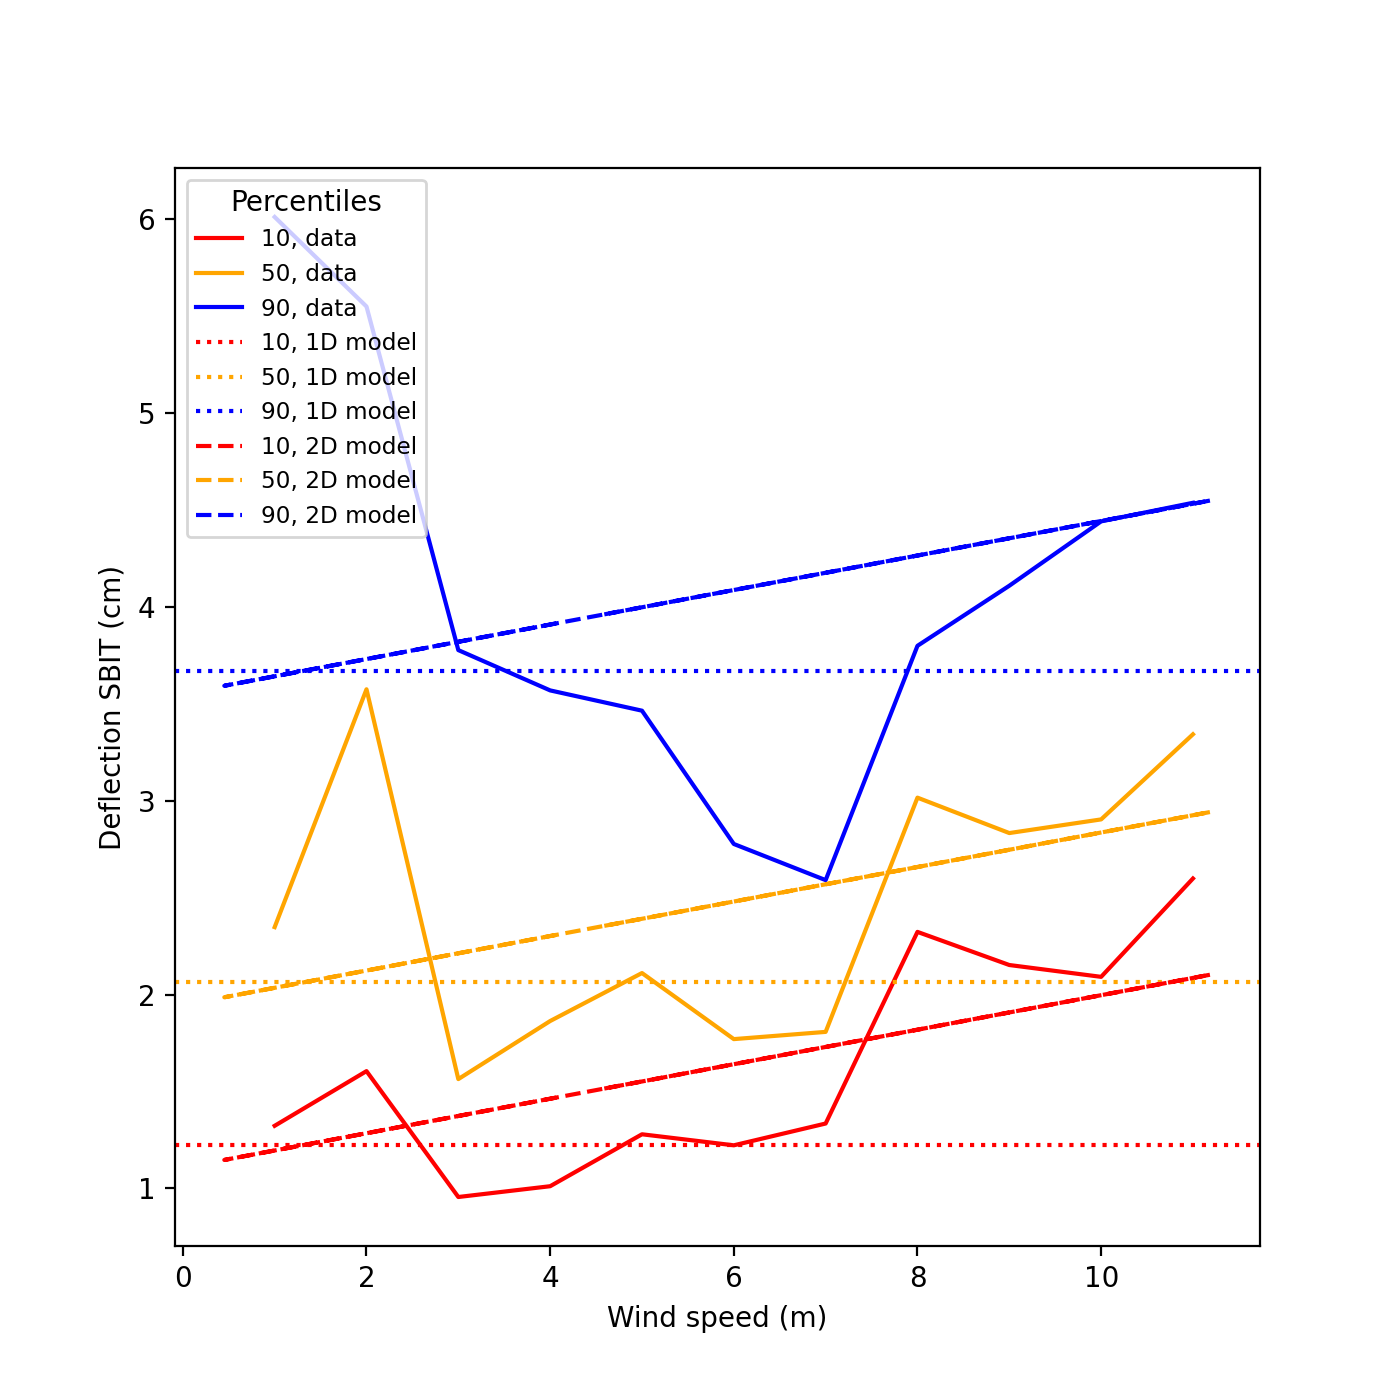

In [50]:
plt.figure(figsize=(7,7))
#plt.scatter(data.waveHeight, data.peakDeflectionTower, color= 'k', alpha= 0.3)
plt.plot(wind_references, quantile10_data, color='r', label='10, data')
plt.plot(wind_references, quantile50_data, color='orange', label='50, data')
plt.plot(wind_references, quantile90_data, color='b', label='90, data')

plt.axhline(y=quantiles1D_10, color='r', linestyle=':',  label='10, 1D model')
plt.axhline(y=quantiles1D_50, color='orange', linestyle=':',  label='50, 1D model')
plt.axhline(y=quantiles1D_90, color='b', linestyle=':',  label='90, 1D model')

plt.plot(data.windSpeed, quantiles2D_10, color='r', label='10, 2D model', linestyle='--')
plt.plot(data.windSpeed, quantiles2D_50, color='orange', label='50, 2D model', linestyle='--')
plt.plot(data.windSpeed, quantiles2D_90, color='b', label='90, 2D model', linestyle='--')

plt.xlabel('Wind speed (m)')
plt.ylabel('Deflection SBIT (cm)')
plt.legend(title='Percentiles', loc=2, fontsize='small', fancybox=True)